In [ ]:
from keras.applications.vgg16 import VGG16
from keras import backend as K
K.set_image_data_format('channels_last')

# Note that we are including the densely-connected classifier on top;
# all previous times, we were discarding it.
model = VGG16(weights='imagenet')

In [ ]:
from keras.preprocessing import image
from keras.applications.vgg16 import preprocess_input, decode_predictions
import numpy as np

# The local path to our target image
img_path = '/content/drive/MyDrive/Phd_Data_set_Implementation/Aug-Training-four/EL/HL_0_1004.jpeg'

# `img` is a PIL image of size 224x224
img = image.load_img(img_path, target_size=(224, 224))

# `x` is a float32 Numpy array of shape (224, 224, 3)
x = image.img_to_array(img)

# We add a dimension to transform our array into a "batch"
# of size (1, 224, 224, 3)
x = np.expand_dims(x, axis=0)

# Finally we preprocess the batch
# (this does channel-wise color normalization)
x = preprocess_input(x)

In [ ]:

preds = model.predict(x)
print('Predicted:', decode_predictions(preds, top=3)[0])

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:2325: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


Predicted: [('n07714571', 'head_cabbage', 0.05172411), ('n04209133', 'shower_cap', 0.045453798), ('n03272010', 'electric_guitar', 0.043521002)]


In [ ]:
preds.shape

(1, 1000)

In [ ]:
np.argmax(preds[0])

936

In [ ]:

layer_names = ['block1_conv1', 'block1_conv2', 
               'block2_conv1', 'block2_conv2', 
               'block3_conv1', 'block3_conv2', 'block3_conv3', 
               'block4_conv1', 'block4_conv2', 'block4_conv3', 
               'block5_conv1', 'block5_conv2', 'block5_conv3']

In [ ]:
# # This is the entry in the prediction vector
# pred_vector_output = model.output[:, 386]

# heatmap = []
# for layer_name in layer_names:
#     # The is the output feature map of the given layer, in VGG16
#     some_conv_layer = model.get_layer(layer_name)

#     # This is the gradient of the predicted class with regard to
#     # the output feature map of selected block

# import tensorflow as tf

# # model = tf.keras.models.Sequential(
# #     [
# #         tf.keras.layers.Dense(10, input_shape=(3,), name="fc1", activation="relu"),
# #         tf.keras.layers.Dense(3, input_shape=(3,), name="fc2"),
# #     ]
# # )

# # # build a new model
# # output_layer = model.outputs
# # all_layers = [layer.output for layer in model.layers]
# grad_model = tf.keras.model(inputs=model.inputs, outputs=layer_names)

# #inputs = tf.ones((1, 299, 299, 3))
# with tf.GradientTape() as tape:
#     some_conv_layer.output = grad_model(inputs)
#     pred_vector_output = output_layer[-1]  # last layer is output layer
#     # take gradients of last layer with respect to all layers in the model
#     grads = tape.gradient(pred_vector_output, some_conv_layer.output)[0]
#     # note: grads[-1] should be all 1, since it it d(output)/d(output)
# #print(grads)

#     #grads = K.gradients(pred_vector_output, some_conv_layer.output)[0]

#     # This is a vector of shape (512,), where each entry
#     # is the mean intensity of the gradient over a specific feature map channel
#     pooled_grads = K.mean(grads, axis=(0, 1, 2))

#     # This function allows us to access the values of the quantities we just defined:
#     # `pooled_grads` and the output feature map of `block5_conv3`,
#     # given a sample image
#     iterate = K.function([model.input], [pooled_grads, some_conv_layer.output[0]])

#     # These are the values of these two quantities, as Numpy arrays,
#     # given our sample image of two elephants
#     pooled_grads_value, conv_layer_output_value = iterate([x])

#     # We multiply each channel in the feature map array
#     # by "how important this channel is" with regard to the elephant class
#     for i in range(model.get_layer(layer_name).output_shape[-1]):
#         conv_layer_output_value[:, :, i] *= pooled_grads_value[i]

#     # The channel-wise mean of the resulting feature map
#     # is our heatmap of class activation
#     heatmap.append(np.mean(conv_layer_output_value, axis=-1))

AttributeError: ignored

In [ ]:

# This is the entry in the prediction vector
pred_vector_output = model.output[:, 386]

import tensorflow as tf
tf.compat.v1.disable_eager_execution()

from tensorflow.python.framework.ops import disable_eager_execution

disable_eager_execution()

heatmap = []
for layer_name in layer_names:
    # The is the output feature map of the given layer, in VGG16
    some_conv_layer = model.get_layer(layer_name)


    # This is the gradient of the predicted class with regard to
    # the output feature map of selected block
    grads = K.gradients(pred_vector_output, some_conv_layer.output)[0]

    # This is a vector of shape (512,), where each entry
    # is the mean intensity of the gradient over a specific feature map channel
    pooled_grads = K.mean(grads, axis=(0, 1, 2))

    # This function allows us to access the values of the quantities we just defined:
    # `pooled_grads` and the output feature map of `block5_conv3`,
    # given a sample image
    iterate = K.function([model.input], [pooled_grads, some_conv_layer.output[0]])

    # These are the values of these two quantities, as Numpy arrays,
    # given our sample image of two elephants
    pooled_grads_value, conv_layer_output_value = iterate([x])

    # We multiply each channel in the feature map array
    # by "how important this channel is" with regard to the elephant class
    for i in range(model.get_layer(layer_name).output_shape[-1]):
        conv_layer_output_value[:, :, i] *= pooled_grads_value[i]

    # The channel-wise mean of the resulting feature map
    # is our heatmap of class activation
    heatmap.append(np.mean(conv_layer_output_value, axis=-1))

In [ ]:
len(heatmap)

13

In [ ]:
from matplotlib import pyplot as plt
%matplotlib inline

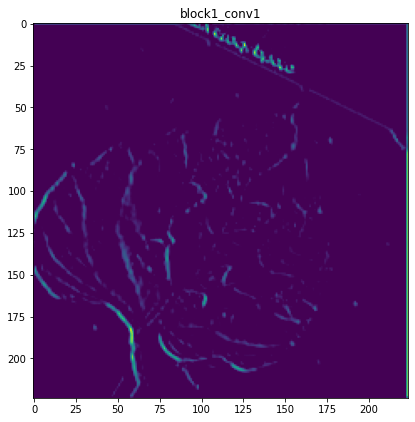

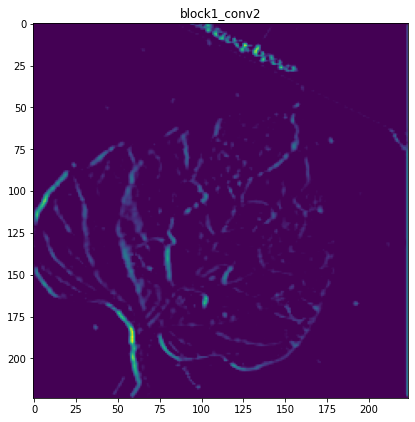

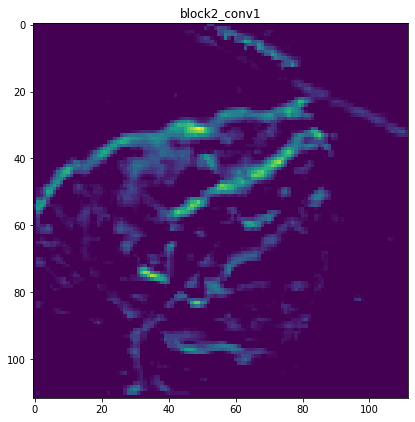

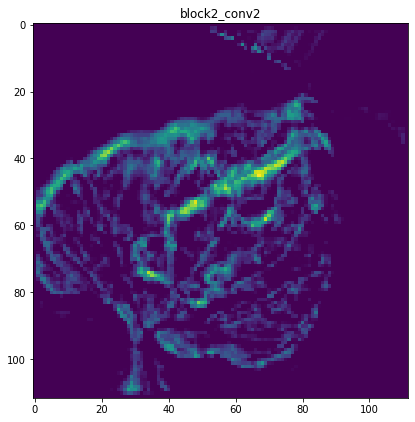

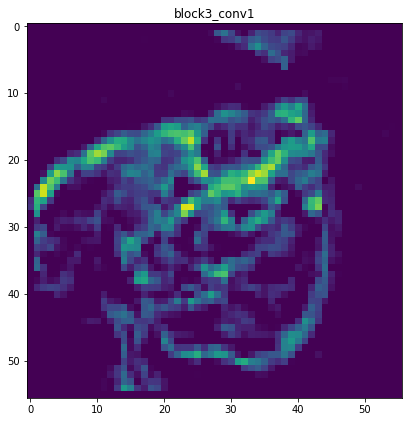

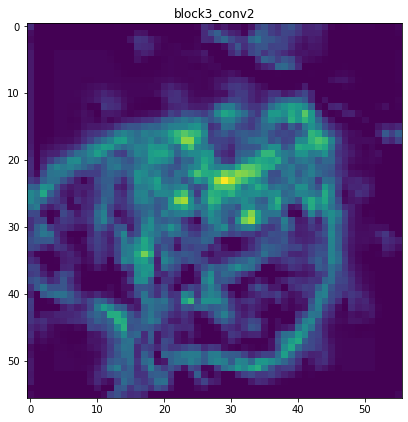

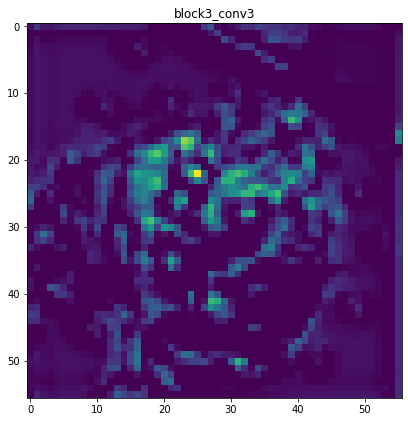

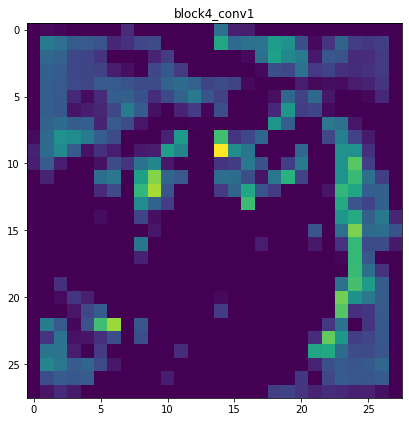

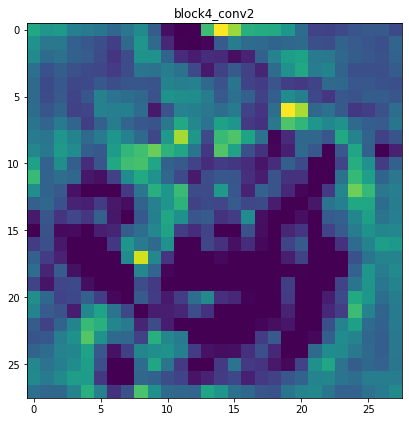

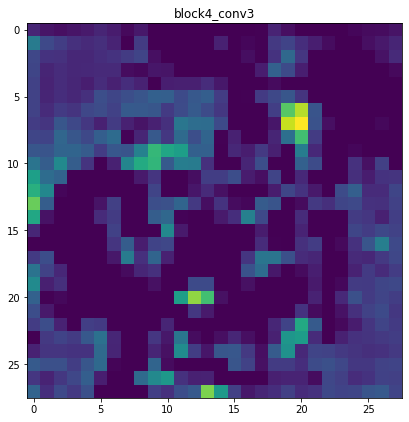

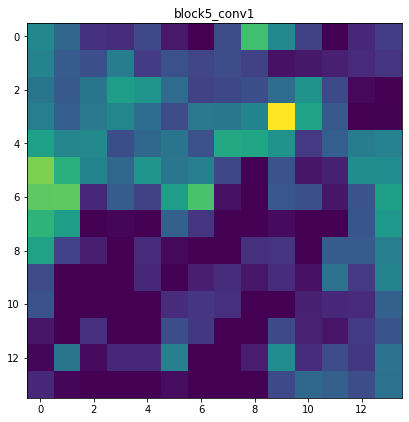

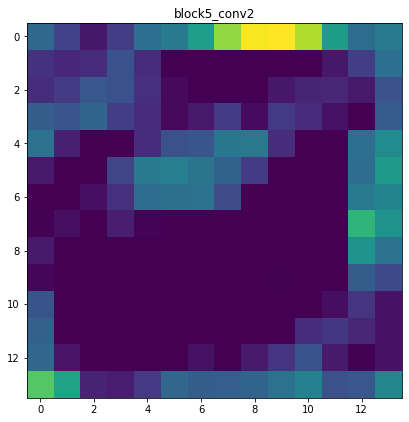

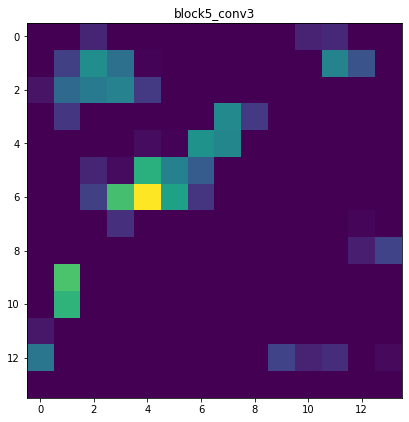

In [ ]:
for i in range(13):
    plt.figure(figsize=(40,40))
    plt.subplot(5, 3, i+1)
    img_heatmap = np.maximum(heatmap[i], 0)
    img_heatmap /= np.max(img_heatmap)
    plt.imshow(img_heatmap)
    plt.title(layer_names[i])
    plt.show()

In [ ]:
import cv2
# We use cv2 to load the original image
img = cv2.imread(img_path)
for i, hm in enumerate(heatmap):
    img_heatmap = np.maximum(hm, 0)
    img_heatmap /= np.max(img_heatmap)
    
    # We resize the heatmap to have the same size as the original image
    img_hm = cv2.resize(img_heatmap, (img.shape[1], img.shape[0]))

    # We convert the heatmap to RGB
    img_hm = np.uint8(255 * img_hm)

    # We apply the heatmap to the original image
    img_hm = cv2.applyColorMap(img_hm, cv2.COLORMAP_JET)

    # 0.4 here is a heatmap intensity factor
    superimposed_img = img_hm * 0.4 + img

    # Save the image to disk
    cv2.imwrite('./elephant_{}.jpg'.format(layer_names[i]), superimposed_img)

TypeError: ignored